In [1]:
import pandas as pd
import numpy as np
import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys

quandl_api_key = '_umNYuQHdkCgs9Rcm4Fv'

In [2]:
df_es = pd.read_csv('/Users/kush/Desktop/futures_data/EP.csv', sep='\t')
df_nq = pd.read_csv('/Users/kush/Desktop/futures_data/ENQ.csv', sep='\t')

In [3]:
###### S&P ######

# Combine the date and time columns into a single datetime column
df_es['datetime'] = pd.to_datetime(df_es['<DATE>'] + ' ' + df_es['<TIME>'])

# Drop the unnecessary columns
df_es = df_es.drop(columns=['<DATE>', '<TIME>', '<TICKVOL>', '<VOL>', '<SPREAD>'])

# Rename columns to remove symbols and make them lowercase
df_es.columns = [col.replace('<', '').replace('>', '').lower() for col in df_es.columns]
df_es = df_es[['datetime', 'open', 'high', 'low', 'close']]

# Display the updated dataframe
df_es.head()

###### NASDAQ ######

# Combine the date and time columns into a single datetime column
df_nq['datetime'] = pd.to_datetime(df_nq['<DATE>'] + ' ' + df_nq['<TIME>'])

# Drop the unnecessary columns
df_nq = df_nq.drop(columns=['<DATE>', '<TIME>', '<TICKVOL>', '<VOL>', '<SPREAD>'])

# Rename columns to remove symbols and make them lowercase
df_nq.columns = [col.replace('<', '').replace('>', '').lower() for col in df_nq.columns]
df_nq = df_nq[['datetime', 'open', 'high', 'low', 'close']]

# Display the updated dataframe
#df_nq.head()


In [4]:
df_es = df_es[-100:]
df_nq = df_nq[-100:]
df_es.set_index('datetime', inplace=True)
df_nq.set_index('datetime', inplace=True)

#shift the datetime index to EST timezone
df_es.index = df_es.index - pd.Timedelta('4 hours')
df_nq.index = df_nq.index - pd.Timedelta('4 hours')

In [5]:
def identify_swing_points(df, window_size, interpolation_method='interpolate'):
    # Calculate half window size
    half_window_size = window_size // 2
    
    # Create a new column 'swing_points' initialized with NaN values
    column_name = f'swing_points_{window_size}'
    df[column_name] = float('nan')
    
    # Initialize variables to keep track of the most recent swing point and its type (high or low)
    last_swing_type = None
    last_swing_index = None
    
    # Iterate through the DataFrame
    for i in range(half_window_size, len(df) - half_window_size):
        # Define the lookback window (centered around current index - half window size)
        lookback_window = df.iloc[i - half_window_size : i + half_window_size + 1]
        center_index = i - half_window_size
        
        # Check if the current high is greater than the highs in the lookback window
        is_swing_high = df.iloc[center_index]['high'] == lookback_window['high'].max()
        # Check if the current low is lower than the lows in the lookback window
        is_swing_low = df.iloc[center_index]['low'] == lookback_window['low'].min()
        
        # Identify swing high points
        if is_swing_high and (last_swing_type != 'high' or df.iloc[center_index]['high'] > df.iloc[last_swing_index][column_name]):
            if last_swing_type == 'high' and last_swing_index is not None:
                df.iloc[last_swing_index, df.columns.get_loc(column_name)] = float('nan')
            df.iloc[center_index, df.columns.get_loc(column_name)] = df.iloc[center_index]['high']
            last_swing_type = 'high'
            last_swing_index = center_index
            
        # Identify swing low points
        elif is_swing_low and (last_swing_type != 'low' or df.iloc[center_index]['low'] < df.iloc[last_swing_index][column_name]):
            if last_swing_type == 'low' and last_swing_index is not None:
                df.iloc[last_swing_index, df.columns.get_loc(column_name)] = float('nan')
            df.iloc[center_index, df.columns.get_loc(column_name)] = df.iloc[center_index]['low']
            last_swing_type = 'low'
            last_swing_index = center_index
    
    # Interpolate or forward fill the NaN values based on the specified interpolation method
    if interpolation_method == 'interpolate':
        df[column_name].interpolate(method='linear', inplace=True)
    elif interpolation_method == 'ffill':
        df[column_name].fillna(method='ffill', inplace=True)
        df[column_name] = df[column_name].shift(window_size + 1)
    
    return df

In [6]:
# Test the function on the provided data
lookback = 20
for window in [1, 5, 15, 60, 240, 1440]:
    df_es = identify_swing_points(df_es, window_size=window, interpolation_method='ffill')
    df_nq = identify_swing_points(df_nq, window_size=window, interpolation_method='ffill')

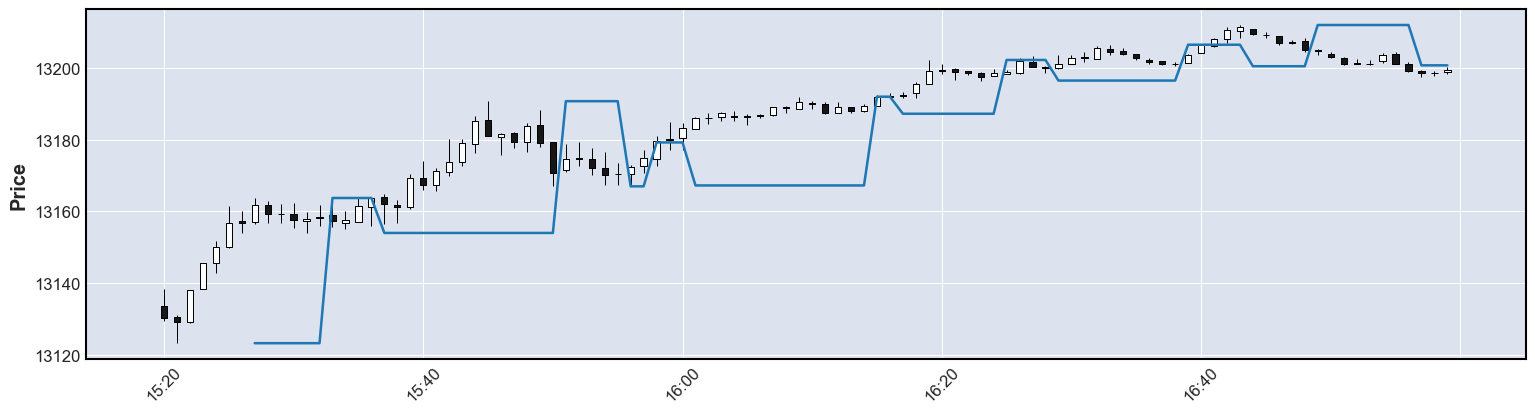

In [7]:
df_temp = df_nq[:100]
mpf.plot(df_temp, type='candle', addplot=mpf.make_addplot(df_temp['swing_points_5']), figsize=(20,5))

In [6]:
# calculate pivot points
def calculate_zigzag(df, timeframes):
    df = df.copy(deep=True)
    for timeframe in timeframes:
        # Resample the DataFrame to the specified timeframe and forward-fill missing values
        resampled_df = df.resample(timeframe).agg({'open' : 'first', 'high' : 'max', 'low' : 'min', 'close' : 'last'}).dropna()

        # Calculate the zigzag values based on high and low OHLC data
        high = resampled_df['high']
        low = resampled_df['low']
        global zigzag
        zigzag = pd.Series(index=resampled_df.index)
        trend = 'up'
        last_high = None
        last_low = None
        for i in range(len(resampled_df)):
            if last_high is None and last_low is None:
                # Add the first high or low value as the starting point
                if high.iloc[i] >= low.iloc[i]:
                    last_high = high.iloc[i]
                    zigzag.iloc[i] = last_high
                else:
                    last_low = low.iloc[i]
                    zigzag.iloc[i] = last_low
            elif last_high is not None and low.iloc[i] <= last_high:
                # Add a low value only if the previous value was high
                last_low = low.iloc[i]
                zigzag.iloc[i] = last_low
                last_high = None
            elif last_low is not None and high.iloc[i] >= last_low:
                # Add a high value only if the previous value was low
                last_high = high.iloc[i]
                zigzag.iloc[i] = last_high
                last_low = None

        # Add the zigzag values as a new feature to the original DataFrame
        df[f'zigzag_{timeframe}'] = zigzag.reindex(df.index).ffill()
        df[f'zigzag_{timeframe}'] = df[f'zigzag_{timeframe}'].shift(freq=timeframe)
        if timeframe == '60T':
            print(zigzag)
            sys.exit()

    return df

# get unique values of a list in order
def get_uniques(s):
    unique_values = []
    for k, g in itertools.groupby(s):
        unique_values.append(k)
    return unique_values

# get past 20 pivot points
def pivots(df, c, lookback, i = None, get_next_pivot=False):
    df = df.copy(deep=True)
    all_data = df[c]
    past_data = df[c][:i+1]
    
    past_pivots = get_uniques(past_data)
    
    if get_next_pivot:
        all_pivots = get_uniques(all_data)
        future_pivots = all_pivots[len(past_pivots):]
        next_pivot = future_pivots[0] if len(future_pivots) != 0 else 0    
        # if math.isnan(next_pivot) and i > 1000 and '60' in c:
        #     print('all pivots:: ', all_pivots)
        #     print('past pivots:: ', past_pivots)
        #     print('future pivots: ', future_pivots)
        #     print('next value: ', next_pivot)
        #     sys.exit()
        return (0 if math.isnan(next_pivot) else next_pivot)
    else:
        past_pivots = past_pivots[-lookback:]
        pivot_list = [np.nan] * (lookback - len(past_pivots)) + past_pivots #pad the list to keep it a length of {lookback}

        return list(pd.Series(pivot_list).fillna(0))

# get and add past {lookback} pivot points array for each row
def pivots_to_feature(df, lookback, get_next_pivot=False):
    df = df.copy(deep=True)

    #final_pivot_cols = [c for c in df.columns if re.match(r'zigzag_\d{1,4}[TDW]$', c)] #zigzag_##[T or D]
    final_pivot_cols = [c for c in df.columns if re.match(r'swing_points_\d{1,4}$', c)] 
    
    if get_next_pivot:
        for c in final_pivot_cols:
            next_pivot = []
            for i in range(len(df)):
                next_pivot.append(pivots(df, c, lookback, i, True))
            df[f'{c}_next_swing'] = next_pivot
            
            print(f'Added {c} next swing')
        return df

    else:
        #initialize past # lookback pivots columns
        for c in final_pivot_cols:
            df[f'{c}_{lookback}'] = np.zeros(len(df))
        for c in final_pivot_cols:
            pivots_list = []
            for i in range(len(df)):
                pivots_list.append(pivots(df, c, lookback, i, False)) #should return size {lookback} array of past pivot ponits
            df[f'{c}_{lookback}'] = pivots_list
            
            print(f'Added {c} swing features')
            #print('After adding the array to the df: ', type(df.zigzag_1T_20[0]), '\n')

        return df

# Define function to split a column into separate columns
def split_column_pivots(df):
    df = df.copy(deep=True)
    dfs = []
    for col in df.columns:
        if re.match(r'swing_points_\d{1,4}_\d+$', col): #re.match(r'zigzag_\d{1,4}[TDW]_\d+$', col):
            col_names = [f'{col}_{i+1}' for i in range(lookback)]
            split_columns = pd.DataFrame(df[col].tolist(), columns=col_names, index=df.index)
            dfs.append(split_columns)
        else:
            dfs.append(df[col])
    return pd.concat(dfs, axis=1)

In [9]:
df_es = pivots_to_feature(df_es, lookback)
df_es = pivots_to_feature(df_es, lookback, get_next_pivot=True)

df_nq = pivots_to_feature(df_nq, lookback)
df_nq = pivots_to_feature(df_nq, lookback, get_next_pivot=True)

# timeframes = ['1T', '5T', '15T', '60T', '240T', '1D']
# lookback = 20

# print('ES')
# df_es = calculate_zigzag(df_es, timeframes)
# df_es = pivots_to_feature(df_es, lookback)
# df_es = pivots_to_feature(df_es, lookback, get_next_pivot=True)


# print('NQ')
# df_nq = calculate_zigzag(df_nq, timeframes)
# df_nq = pivots_to_feature(df_nq, lookback)
# df_nq = pivots_to_feature(df_nq, lookback, get_next_pivot=True)

Added swing_points_1 swing features
Added swing_points_5 swing features
Added swing_points_15 swing features
Added swing_points_60 swing features
Added swing_points_240 swing features
Added swing_points_1440 swing features
Added swing_points_1 next swing
Added swing_points_5 next swing
Added swing_points_15 next swing
Added swing_points_60 next swing
Added swing_points_240 next swing
Added swing_points_1440 next swing
Added swing_points_1 swing features
Added swing_points_5 swing features
Added swing_points_15 swing features
Added swing_points_60 swing features
Added swing_points_240 swing features
Added swing_points_1440 swing features
Added swing_points_1 next swing
Added swing_points_5 next swing
Added swing_points_15 next swing
Added swing_points_60 next swing
Added swing_points_240 next swing
Added swing_points_1440 next swing


In [10]:
# split past {lookback} value from array into their own columns (this will create {lookback} new columns)
df_es = split_column_pivots(df_es)
df_nq = split_column_pivots(df_nq)

In [11]:
pivot_cols_to_drop = [c for c in df_es.columns if re.match(r'^swing_points_\d{1,4}_\d+$|^swing_points_\d{1,4}$', c)] #drop the zigzag rows and the array rows, keep only the flattened rows
df_es.drop(columns=pivot_cols_to_drop, inplace=True)
df_nq.drop(columns=pivot_cols_to_drop, inplace=True)

In [7]:
def identify_fair_value_gaps(df, timeframes):
    df = df.copy(deep=True)
    df_with_fvg = df.copy(deep=True)
    for timeframe in timeframes:
        fair_value_gaps = []
        resampled_df = df.resample(timeframe).agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'})
        for i in range(2, len(resampled_df)):
            if resampled_df['high'].iloc[i-2] < resampled_df['low'].iloc[i]:
                fair_value_gaps.append(1)
            elif resampled_df['low'].iloc[i-2] > resampled_df['high'].iloc[i]:
                fair_value_gaps.append(1)
            else:
                fair_value_gaps.append(0)
        fvg_col_name = f'fair_value_gap_{timeframe}'
        df_with_fvg[fvg_col_name] = pd.Series(fair_value_gaps, index=resampled_df.index[2:]).fillna(False)
        df_with_fvg[fvg_col_name].fillna(0, inplace=True)
    return df_with_fvg

# get and add past {lookback} fvg array for each row
def fvg_to_feature(df):
    df = df.copy(deep=True)

    final_fvg_cols = [c for c in df.columns if re.match(r'fair_value_gap_\d{1,4}[TDW]$', c)]
    #initialize past # lookback fvg columns
    for c in final_fvg_cols:
        df[f'{c}_{lookback}'] = np.zeros(len(df))

    for c in final_fvg_cols:
        deltas_list = []
        for i in range(len(df)):
            temp_df = df[c][:i]
            deltas = [(temp_df.index[-1] - date).seconds//60 for date in temp_df[temp_df == 1].index]
            deltas = [np.nan] * (lookback - len(deltas)) + deltas
            deltas_list.append(deltas[-lookback:])
        df[f'{c}_{lookback}'] = deltas_list
        print(f'Added {c} fvg features')
        
    return df

# Define function to split a column into separate columns
def split_column_fvg(df):
    df = df.copy(deep=True)
    dfs = []
    for col in df.columns:
        if re.match(r'fair_value_gap_\d{1,4}[TDW]_\d+$', col):
            col_names = [f'{col}_{i+1}' for i in range(lookback)]
            split_columns = pd.DataFrame(df[col].tolist(), columns=col_names, index=df.index)
            dfs.append(split_columns)
        else:
            dfs.append(df[col])
    return pd.concat(dfs, axis=1)


In [13]:
timeframes = ['1T', '5T', '15T', '60T', '240T', '1D']
lookback = 20
print('ES')
df_es = identify_fair_value_gaps(df_es, timeframes)
df_es = fvg_to_feature(df_es)


print('NQ')
df_nq = identify_fair_value_gaps(df_nq, timeframes)
df_nq = fvg_to_feature(df_nq)

ES
Added fair_value_gap_1T fvg features
Added fair_value_gap_5T fvg features
Added fair_value_gap_15T fvg features
Added fair_value_gap_60T fvg features
Added fair_value_gap_240T fvg features
Added fair_value_gap_1D fvg features
NQ
Added fair_value_gap_1T fvg features
Added fair_value_gap_5T fvg features
Added fair_value_gap_15T fvg features
Added fair_value_gap_60T fvg features
Added fair_value_gap_240T fvg features
Added fair_value_gap_1D fvg features


In [14]:
# split past {lookback} value from array into their own columns (this will create {lookback} new columns)
df_es = split_column_fvg(df_es)
df_nq = split_column_fvg(df_nq)

In [15]:
fvg_cols_to_drop = [c for c in df_es.columns if re.match(r'^fair_value_gap_\d{1,4}[TD]_\d+$|^fair_value_gap_\d{1,4}[TDW]$', c)]

df_es.drop(columns=fvg_cols_to_drop, inplace=True)
df_nq.drop(columns=fvg_cols_to_drop, inplace=True)

In [8]:
df_list = []
for df in [df_es, df_nq]:
        #df = pd.read_csv(data)
        
        # Step 1: Get swing points for each window
        lookback = 20
        for window in [1, 5, 15, 60, 240, 1440]:
            df = identify_swing_points(df, window_size=window, interpolation_method='ffill')
           
        # Step 2: Get a list of the past 20 swing points for each time point
        lookback = 20
        df = pivots_to_feature(df, lookback)
        df = pivots_to_feature(df, lookback, get_next_pivot=True)
        
        # Step 3: Put each of the last {lookback} swing points in their own columns
        df = split_column_pivots(df)
        
        # Step 4: Drop columns from Step 1 and Step 2
        pivot_cols_to_drop = [c for c in df_es.columns if re.match(r'^swing_points_\d{1,4}_\d+$|^swing_points_\d{1,4}$', c)]
        df.drop(columns=pivot_cols_to_drop, inplace=True)
        
        # Step 5: Get Fair Value Gaps for each timeframe
        timeframes = ['1T', '5T', '15T', '60T', '240T', '1D']
        df = identify_fair_value_gaps(df, timeframes)
        
        # Step 6: Get list of past {lookback} FVGs
        df = fvg_to_feature(df)
        
        # Step 7: Put each of the last {lookback} FVGs in their own columns
        df = split_column_fvg(df)
        
        # Step 8:   Drop columns from Step 6 and Step 6
        fvg_cols_to_drop = [c for c in df_es.columns if re.match(r'^fair_value_gap_\d{1,4}[TD]_\d+$|^fair_value_gap_\d{1,4}[TDW]$', c)]
        df_es.drop(columns=fvg_cols_to_drop, inplace=True)
        
        df_list.append(df)

Added swing_points_1 swing features
Added swing_points_5 swing features
Added swing_points_15 swing features
Added swing_points_60 swing features
Added swing_points_240 swing features
Added swing_points_1440 swing features
Added swing_points_1 next swing
Added swing_points_5 next swing
Added swing_points_15 next swing
Added swing_points_60 next swing
Added swing_points_240 next swing
Added swing_points_1440 next swing
Added fair_value_gap_1T fvg features
Added fair_value_gap_5T fvg features
Added fair_value_gap_15T fvg features
Added fair_value_gap_60T fvg features
Added fair_value_gap_240T fvg features
Added fair_value_gap_1D fvg features
Added swing_points_1 swing features
Added swing_points_5 swing features
Added swing_points_15 swing features
Added swing_points_60 swing features
Added swing_points_240 swing features
Added swing_points_1440 swing features
Added swing_points_1 next swing
Added swing_points_5 next swing
Added swing_points_15 next swing
Added swing_points_60 next swing

In [11]:
df_list[1]

,open,high,low,close,swing_points_1_20_1,swing_points_1_20_2,swing_points_1_20_3,swing_points_1_20_4,swing_points_1_20_5,swing_points_1_20_6,...,fair_value_gap_1D_20_11,fair_value_gap_1D_20_12,fair_value_gap_1D_20_13,fair_value_gap_1D_20_14,fair_value_gap_1D_20_15,fair_value_gap_1D_20_16,fair_value_gap_1D_20_17,fair_value_gap_1D_20_18,fair_value_gap_1D_20_19,fair_value_gap_1D_20_20
datetime,,,,,,,,,,,,,,,,,,,,,
2023-04-14 15:20:00,13133.75,13138.25,13129.50,13130.25,0.00,0.00,0.00,0.0,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-14 15:21:00,13130.50,13131.25,13123.25,13129.25,0.00,0.00,0.00,0.0,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-14 15:22:00,13129.25,13138.00,13128.75,13138.00,0.00,0.00,0.00,0.0,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-14 15:23:00,13138.25,13145.75,13138.25,13145.50,0.00,0.00,0.00,0.0,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-14 15:24:00,13145.50,13151.75,13142.75,13150.00,0.00,0.00,0.00,0.0,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-14 16:55:00,13204.00,13204.50,13201.00,13201.00,13203.25,13198.75,13203.75,13201.0,13206.50,13203.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-14 16:56:00,13201.25,13201.75,13199.00,13199.25,13203.25,13198.75,13203.75,13201.0,13206.50,13203.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-14 16:57:00,13199.25,13199.50,13197.50,13198.50,13198.75,13203.75,13201.00,13206.5,13203.50,13204.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# DATAFRAME IS READY, NEXT STEP IS TO DO THE MACHINE LEARNING
# TRY IT LOCALLY THEN GO TO SAGEMAKER (DEPENDING ON HOW LOCALLY GOES)

In [86]:
# combine dataset
df = pd.merge(df_es, df_nq, 'inner', 'datetime', suffixes=('_es', '_nq')).copy(deep=True)

# extract year, month, day, hour, minute, and day of week as separate reatures.
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['day_of_week'] = df.index.dayofweek
df = pd.get_dummies(df, 'day_of_week_', columns= ['day_of_week'])

# dataframe is fragemented, t de-fragment it use copy.
# df = df.fillna(-1).copy(deep=True)

/var/folders/8h/72mwhy0j2fd18ttn3cpr4xnw0000gp/T/ipykernel_94245/2148336360.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df = pd.merge(df_list[0], df_list[1], 'inner', 'datetime', suffixes=('_es', '_nq')).copy(deep=True)


In [114]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import FunctionTransformer


# Custom transformer to apply log transformation
class LogTransformer:
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.log(X + 1)  # Add 1 to handle zero values


# Split data into features and target
target_cols = ['swing_points_15_next_swing_es', 'swing_points_15_next_swing_nq']
feature_cols = list(set(df.columns) - set(target_cols))

X = df.drop(columns=target_cols + [c for c in df.columns if 'next' in c]) # also remoe the other 'next_swing' columns that we're not predicing for
y = df[target_cols]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline for preprocessing and modeling
price_cols = [
    col for col in df.columns 
    if any(sub in col for sub in ['open', 'high', 'low', 'close', 'swing_points']) 
    and not any(sub in col for sub in ['next'])
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', FunctionTransformer(LogTransformer().transform), price_cols)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Impute any missing values after log transformation
    ('model', MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=42)))
])
# Fit pipeline to training data
pipeline.fit(X_train, y_train)

# Evaluate pipeline on test data
y_pred = pipeline.predict(X_test)

r2_scores = r2_score(y_test, y_pred, multioutput='raw_values')
mae_scores = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
mse_scores = mean_squared_error(y_test, y_pred, multioutput='raw_values')
rmse_scores = np.sqrt(mse_scores)

for i, (r2, mae, mse, rmse) in enumerate(zip(r2_scores, mae_scores, mse_scores, rmse_scores)):
    print(f'Target {i+1} metrics:')
    print(f'R^2 score: {r2:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')

Target 1 metrics:
R^2 score: 0.54
MAE: 1.66
MSE: 4087.12
RMSE: 63.93
Target 2 metrics:
R^2 score: 0.92
MAE: 8.53
MSE: 43053.89
RMSE: 207.49


In [109]:
import pandas as pd

def get_most_accurate_predictions(y_test, datetime_indexes, y_pred, target_names, N=10):
    most_accurate_dict = {}
    num_targets = y_test.shape[1]
    for target_idx in range(num_targets):
        target_name = target_names[target_idx]
        # Calculate absolute errors for the current target
        absolute_errors = abs(y_test.iloc[:, target_idx] - y_pred[:, target_idx])

        # Create a DataFrame with datetime index, actual values, predicted values, and absolute errors
        accuracy_df = pd.DataFrame({
            'datetime': datetime_indexes,
            'actual': y_test.iloc[:, target_idx],
            'predicted': y_pred[:, target_idx],
            'absolute_error': absolute_errors
        })

        # Sort the DataFrame based on the absolute errors column (ascending order)
        accuracy_df_sorted = accuracy_df.sort_values(by='absolute_error', ascending=True)

        # Store the top N indexes with the most accurate predictions for this target
        most_accurate_dict[target_name] = accuracy_df_sorted.head(N)

    return most_accurate_dict

# Example usage
target_names = ['Target 1', 'Target 2']

# Get the most accurate predictions for each target
most_accurate_predictions_dict = get_most_accurate_predictions(y_test, y_test.index, y_pred, target_names, N=1)

# Display the results for each target
for target_name, most_accurate_df in most_accurate_predictions_dict.items():
    print(f"Most accurate predictions for {target_name}:")
    print(most_accurate_df)
    print()


Most accurate predictions for Target 1:
                               datetime  actual  predicted  absolute_error
datetime                                                                  
2023-04-06 01:31:00 2023-04-06 01:31:00  4105.5     4105.5             0.0

Most accurate predictions for Target 2:
                               datetime    actual  predicted  absolute_error
datetime                                                                    
2023-04-11 08:41:00 2023-04-11 08:41:00  13156.75   13156.75             0.0



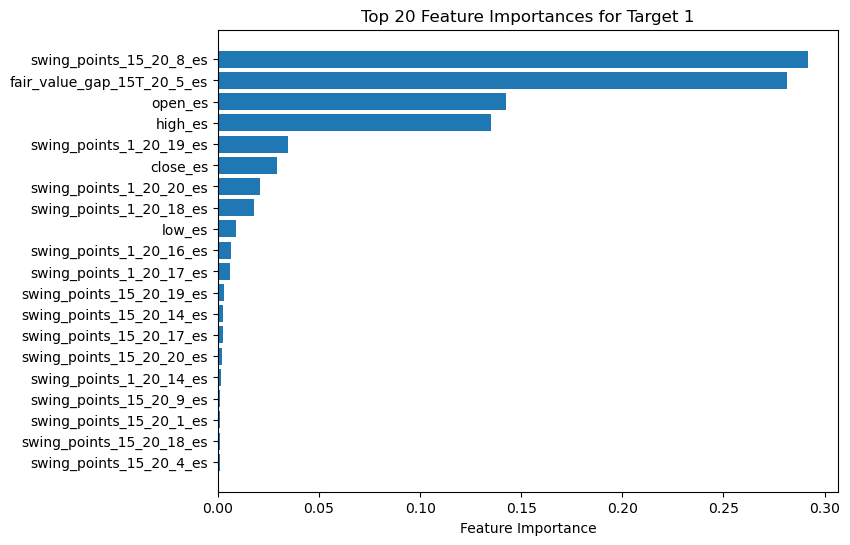

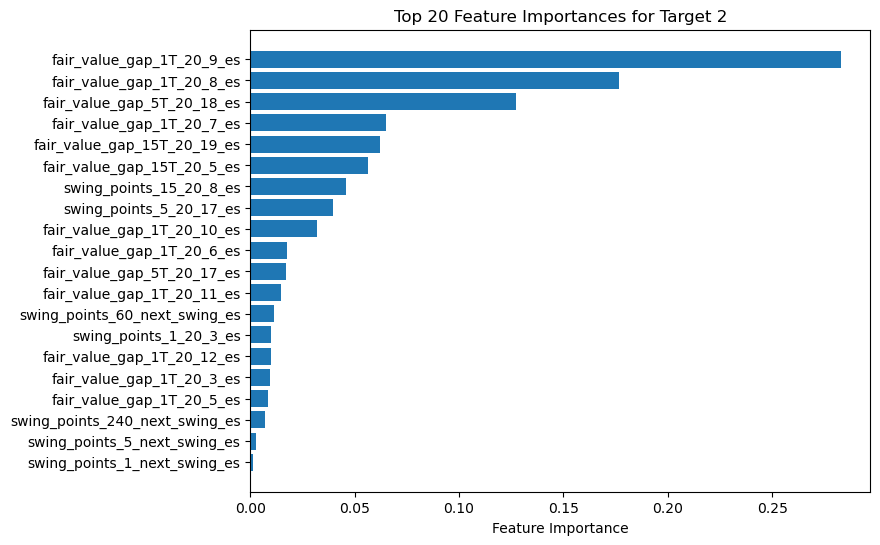

In [113]:
import matplotlib.pyplot as plt

# Assuming 'pipeline' is your trained pipeline with the MultiOutputRegressor
# and 'model' is the name of the MultiOutputRegressor step in the pipeline
multi_output_regressor = pipeline.named_steps['model']

# Assuming 'feature_names' is a list of names of the features used in training the model
feature_names = [c for c in df.columns if c not in cols_to_predict]  # Replace with actual feature names

# Number of top features to display
num_top_features = 20

# Iterate through each target's fitted regressor and plot feature importances
for target_idx, regressor in enumerate(multi_output_regressor.estimators_):
    feature_importances = regressor.feature_importances_
    sorted_idx = feature_importances.argsort()[-num_top_features:]  # Select top 10 indexes
    
    plt.figure(figsize=(8, 6))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {num_top_features} Feature Importances for Target {target_idx + 1}')
    plt.show()

In [112]:
price_cols

['open_es',
 'high_es',
 'low_es',
 'close_es',
 'swing_points_1_20_1_es',
 'swing_points_1_20_2_es',
 'swing_points_1_20_3_es',
 'swing_points_1_20_4_es',
 'swing_points_1_20_5_es',
 'swing_points_1_20_6_es',
 'swing_points_1_20_7_es',
 'swing_points_1_20_8_es',
 'swing_points_1_20_9_es',
 'swing_points_1_20_10_es',
 'swing_points_1_20_11_es',
 'swing_points_1_20_12_es',
 'swing_points_1_20_13_es',
 'swing_points_1_20_14_es',
 'swing_points_1_20_15_es',
 'swing_points_1_20_16_es',
 'swing_points_1_20_17_es',
 'swing_points_1_20_18_es',
 'swing_points_1_20_19_es',
 'swing_points_1_20_20_es',
 'swing_points_5_20_1_es',
 'swing_points_5_20_2_es',
 'swing_points_5_20_3_es',
 'swing_points_5_20_4_es',
 'swing_points_5_20_5_es',
 'swing_points_5_20_6_es',
 'swing_points_5_20_7_es',
 'swing_points_5_20_8_es',
 'swing_points_5_20_9_es',
 'swing_points_5_20_10_es',
 'swing_points_5_20_11_es',
 'swing_points_5_20_12_es',
 'swing_points_5_20_13_es',
 'swing_points_5_20_14_es',
 'swing_points_5_2

In [ ]:
# WERE CHECKING WHICH FEATURE HAS THE MOST IMPORTANCE, LOOK AT CHATGPT